In [4]:
!pip install opentsne==0.6.2

In [5]:
!pip install torchmetrics==0.9.2

In [3]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torch.nn import MaxPool1d
from packaging import version
import json
import os
from functools import lru_cache
from typing import List, Optional, Tuple
import regex as re
from transformers import AddedToken, PreTrainedTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup, RobertaModel, RobertaConfig, RobertaTokenizer
from openTSNE import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from copy import deepcopy
from torchmetrics import R2Score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

np.random.seed(seed=1)

# Datasets

In [6]:
"""Downstream Dataset"""
class Downstream_Dataset(Dataset):
    def __init__(self, dataset, tokenizer, max_token_len):
        self.tokenizer = tokenizer
        self.dataset = dataset
        self.max_token_len = max_token_len

    def __len__(self):
        self.len = len(self.dataset)
        return self.len

    def __getitem__(self, i):
        data_row = self.dataset.iloc[i]
        seq = data_row[0]
        prop = data_row[1]

        encoding = self.tokenizer(
            str(seq),
            add_special_tokens=True,
            max_length=self.max_token_len,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return dict(
            input_ids=encoding["input_ids"].flatten(),
            attention_mask=encoding["attention_mask"].flatten(),
            prop=prop
        )

In [7]:
"""Adapted from RobertaEmbedding"""
class TransPolymerEmbeddings(nn.Module):
    """
    Same as BertEmbeddings with a tiny tweak for positional embeddings indexing.
    """

    # Copied from transformers.models.bert.modeling_bert.BertEmbeddings.__init__
    def __init__(self, config):
        super().__init__()
        self.word_embeddings = nn.Embedding(config.vocab_size, config.hidden_size, padding_idx=config.pad_token_id)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        self.token_type_embeddings = nn.Embedding(config.type_vocab_size, config.hidden_size)

        # self.LayerNorm is not snake-cased to stick with TensorFlow model variable name and be able to load
        # any TensorFlow checkpoint file
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        # position_ids (1, len position emb) is contiguous in memory and exported when serialized
        self.position_embedding_type = getattr(config, "position_embedding_type", "absolute")
        self.register_buffer("position_ids", torch.arange(config.max_position_embeddings).expand((1, -1)))
        if version.parse(torch.__version__) > version.parse("1.6.0"):
            self.register_buffer(
                "token_type_ids",
                torch.zeros(self.position_ids.size(), dtype=torch.long),
                persistent=False,
            )

        # End copy
        self.padding_idx = config.pad_token_id
        self.position_embeddings = nn.Embedding(
            config.max_position_embeddings, config.hidden_size, padding_idx=self.padding_idx
        )

    def forward(
        self, input_ids=None, token_type_ids=None, position_ids=None, inputs_embeds=None, past_key_values_length=0
    ):
        if position_ids is None:
            if input_ids is not None:
                # Create the position ids from the input token ids. Any padded tokens remain padded.
                position_ids = create_position_ids_from_input_ids(input_ids, self.padding_idx, past_key_values_length)
            else:
                position_ids = self.create_position_ids_from_inputs_embeds(inputs_embeds)

        if input_ids is not None:
            input_shape = input_ids.size()
        else:
            input_shape = inputs_embeds.size()[:-1]

        seq_length = input_shape[1]

        # Setting the token_type_ids to the registered buffer in constructor where it is all zeros, which usually occurs
        # when its auto-generated, registered buffer helps users when tracing the model without passing token_type_ids, solves
        # issue #5664
        if token_type_ids is None:
            if hasattr(self, "token_type_ids"):
                buffered_token_type_ids = self.token_type_ids[:, :seq_length]
                buffered_token_type_ids_expanded = buffered_token_type_ids.expand(input_shape[0], seq_length)
                token_type_ids = buffered_token_type_ids_expanded
            else:
                token_type_ids = torch.zeros(input_shape, dtype=torch.long, device=self.position_ids.device)

        if inputs_embeds is None:
            inputs_embeds = self.word_embeddings(input_ids)
        token_type_embeddings = self.token_type_embeddings(token_type_ids)

        embeddings = inputs_embeds + token_type_embeddings
        if self.position_embedding_type == "absolute":
            position_embeddings = self.position_embeddings(position_ids)
            embeddings += position_embeddings
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

    def create_position_ids_from_inputs_embeds(self, inputs_embeds):
        """
        We are provided embeddings directly. We cannot infer which are padded so just generate sequential position ids.
        Args:
            inputs_embeds: torch.Tensor
        Returns: torch.Tensor
        """
        input_shape = inputs_embeds.size()[:-1]
        sequence_length = input_shape[1]

        position_ids = torch.arange(
            self.padding_idx + 1, sequence_length + self.padding_idx + 1, dtype=torch.long, device=inputs_embeds.device
        )
        return position_ids.unsqueeze(0).expand(input_shape)

def create_position_ids_from_input_ids(input_ids, padding_idx, past_key_values_length=0):
    """
    Replace non-padding symbols with their position numbers. Position numbers begin at padding_idx+1. Padding symbols
    are ignored. This is modified from fairseq's `utils.make_positions`.
    Args:
        x: torch.Tensor x:
    Returns: torch.Tensor
    """
    # The series of casts and type-conversions here are carefully balanced to both work with ONNX export and XLA.
    mask = input_ids.ne(padding_idx).int()
    incremental_indices = (torch.cumsum(mask, dim=1).type_as(mask) + past_key_values_length) * mask
    return incremental_indices.long() + padding_idx

In [8]:
class Dataset_Emb(Dataset):
    def __init__(self, dataset, tokenizer, max_token_len, config):
        self.tokenizer = tokenizer
        self.dataset = dataset
        self.max_token_len = max_token_len
        self.Embeddings = TransPolymerEmbeddings(config)

    def __len__(self):
        self.len = len(self.dataset)
        return self.len

    def __getitem__(self, i):
        data_row = self.dataset.iloc[i]
        smiles = data_row[0]

        encoding = self.tokenizer(
            str(smiles),
            add_special_tokens=True,
            max_length=self.max_token_len,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return self.Embeddings(input_ids=encoding["input_ids"])

# PolymerSmilesTokenizer (Adaptado do RoBERTaTokenizer)

In [9]:
VOCAB_FILES_NAMES = {
    "vocab_file": "vocab.json",
    "merges_file": "merges.txt",
}

PRETRAINED_VOCAB_FILES_MAP = {
    "vocab_file": {
        "roberta-base": "https://huggingface.co/roberta-base/resolve/main/vocab.json",
        "roberta-large": "https://huggingface.co/roberta-large/resolve/main/vocab.json",
        "roberta-large-mnli": "https://huggingface.co/roberta-large-mnli/resolve/main/vocab.json",
        "distilroberta-base": "https://huggingface.co/distilroberta-base/resolve/main/vocab.json",
        "roberta-base-openai-detector": "https://huggingface.co/roberta-base-openai-detector/resolve/main/vocab.json",
        "roberta-large-openai-detector": "https://huggingface.co/roberta-large-openai-detector/resolve/main/vocab.json",
    },
    "merges_file": {
        "roberta-base": "https://huggingface.co/roberta-base/resolve/main/merges.txt",
        "roberta-large": "https://huggingface.co/roberta-large/resolve/main/merges.txt",
        "roberta-large-mnli": "https://huggingface.co/roberta-large-mnli/resolve/main/merges.txt",
        "distilroberta-base": "https://huggingface.co/distilroberta-base/resolve/main/merges.txt",
        "roberta-base-openai-detector": "https://huggingface.co/roberta-base-openai-detector/resolve/main/merges.txt",
        "roberta-large-openai-detector": "https://huggingface.co/roberta-large-openai-detector/resolve/main/merges.txt",
    },
}

PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES = {
    "roberta-base": 512,
    "roberta-large": 512,
    "roberta-large-mnli": 512,
    "distilroberta-base": 512,
    "roberta-base-openai-detector": 512,
    "roberta-large-openai-detector": 512,
}


@lru_cache()
def bytes_to_unicode():
    """
    Returns list of utf-8 byte and a mapping to unicode strings. We specifically avoids mapping to whitespace/control
    characters the bpe code barfs on.

    The reversible bpe codes work on unicode strings. This means you need a large # of unicode characters in your vocab
    if you want to avoid UNKs. When you're at something like a 10B token dataset you end up needing around 5K for
    decent coverage. This is a significant percentage of your normal, say, 32K bpe vocab. To avoid that, we want lookup
    tables between utf-8 bytes and unicode strings.
    """
    bs = (
        list(range(ord("!"), ord("~") + 1)) + list(range(ord("¡"), ord("¬") + 1)) + list(range(ord("®"), ord("ÿ") + 1))
    )
    cs = bs[:]
    n = 0
    for b in range(2**8):
        if b not in bs:
            bs.append(b)
            cs.append(2**8 + n)
            n += 1
    cs = [chr(n) for n in cs]
    return dict(zip(bs, cs))


def get_pairs(word):
    """
    Return set of symbol pairs in a word.

    Word is represented as tuple of symbols (symbols being variable-length strings).
    """
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs

class PolymerSmilesTokenizer(PreTrainedTokenizer):
    """Adapt Roberta Tokenizer to PolymerSmilesTokenzier"""

    """
    Original Comments:

    Constructs a RoBERTa tokenizer, derived from the GPT-2 tokenizer, using byte-level Byte-Pair-Encoding.

    This tokenizer has been trained to treat spaces like parts of the tokens (a bit like sentencepiece) so a word will
    be encoded differently whether it is at the beginning of the sentence (without space) or not:

    ```
    #>>> from transformers import RobertaTokenizer
    #>>> tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
    #>>> tokenizer("Hello world")['input_ids']
    [0, 31414, 232, 328, 2]
    #>>> tokenizer(" Hello world")['input_ids']
    [0, 20920, 232, 2]
    ```

    You can get around that behavior by passing `add_prefix_space=True` when instantiating this tokenizer or when you
    call it on some text, but since the model was not pretrained this way, it might yield a decrease in performance.

    <Tip>

    When used with `is_split_into_words=True`, this tokenizer will add a space before each word (even the first one).

    </Tip>

    This tokenizer inherits from [`PreTrainedTokenizer`] which contains most of the main methods. Users should refer to
    this superclass for more information regarding those methods.

    Args:
        vocab_file (`str`):
            Path to the vocabulary file.
        merges_file (`str`):
            Path to the merges file.
        errors (`str`, *optional*, defaults to `"replace"`):
            Paradigm to follow when decoding bytes to UTF-8. See
            [bytes.decode](https://docs.python.org/3/library/stdtypes.html#bytes.decode) for more information.
        bos_token (`str`, *optional*, defaults to `"<s>"`):
            The beginning of sequence token that was used during pretraining. Can be used a sequence classifier token.

            <Tip>

            When building a sequence using special tokens, this is not the token that is used for the beginning of
            sequence. The token used is the `cls_token`.

            </Tip>

        eos_token (`str`, *optional*, defaults to `"</s>"`):
            The end of sequence token.

            <Tip>

            When building a sequence using special tokens, this is not the token that is used for the end of sequence.
            The token used is the `sep_token`.

            </Tip>

        sep_token (`str`, *optional*, defaults to `"</s>"`):
            The separator token, which is used when building a sequence from multiple sequences, e.g. two sequences for
            sequence classification or for a text and a question for question answering. It is also used as the last
            token of a sequence built with special tokens.
        cls_token (`str`, *optional*, defaults to `"<s>"`):
            The classifier token which is used when doing sequence classification (classification of the whole sequence
            instead of per-token classification). It is the first token of the sequence when built with special tokens.
        unk_token (`str`, *optional*, defaults to `"<unk>"`):
            The unknown token. A token that is not in the vocabulary cannot be converted to an ID and is set to be this
            token instead.
        pad_token (`str`, *optional*, defaults to `"<pad>"`):
            The token used for padding, for example when batching sequences of different lengths.
        mask_token (`str`, *optional*, defaults to `"<mask>"`):
            The token used for masking values. This is the token used when training this model with masked language
            modeling. This is the token which the model will try to predict.
        add_prefix_space (`bool`, *optional*, defaults to `False`):
            Whether or not to add an initial space to the input. This allows to treat the leading word just as any
            other word. (RoBERTa tokenizer detect beginning of words by the preceding space).
    """

    vocab_files_names = VOCAB_FILES_NAMES
    pretrained_vocab_files_map = PRETRAINED_VOCAB_FILES_MAP
    max_model_input_sizes = PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES
    model_input_names = ["input_ids", "attention_mask"]

    def __init__(
        self,
        vocab_file,
        merges_file,
        errors="replace",
        bos_token="<s>",
        eos_token="</s>",
        sep_token="</s>",
        cls_token="<s>",
        unk_token="<unk>",
        pad_token="<pad>",
        mask_token="<mask>",
        add_prefix_space=False,
        **kwargs
    ):
      bos_token = AddedToken(bos_token, lstrip=False, rstrip=False) if isinstance(bos_token, str) else bos_token
      eos_token = AddedToken(eos_token, lstrip=False, rstrip=False) if isinstance(eos_token, str) else eos_token
      sep_token = AddedToken(sep_token, lstrip=False, rstrip=False) if isinstance(sep_token, str) else sep_token
      cls_token = AddedToken(cls_token, lstrip=False, rstrip=False) if isinstance(cls_token, str) else cls_token
      unk_token = AddedToken(unk_token, lstrip=False, rstrip=False) if isinstance(unk_token, str) else unk_token
      pad_token = AddedToken(pad_token, lstrip=False, rstrip=False) if isinstance(pad_token, str) else pad_token

      # Mask token behave like a normal word, i.e. include the space before it
      mask_token = AddedToken(mask_token, lstrip=True, rstrip=False) if isinstance(mask_token, str) else mask_token

      super().__init__(
          errors=errors,
          bos_token=bos_token,
          eos_token=eos_token,
          unk_token=unk_token,
          sep_token=sep_token,
          cls_token=cls_token,
          pad_token=pad_token,
          mask_token=mask_token,
          add_prefix_space=add_prefix_space,
          **kwargs,
      )

      with open(vocab_file, encoding="utf-8") as vocab_handle:
        self.encoder = json.load(vocab_handle)
      self.decoder = {v: k for k, v in self.encoder.items()}
      self.errors = errors  # how to handle errors in decoding
      self.byte_encoder = bytes_to_unicode()
      self.byte_decoder = {v: k for k, v in self.byte_encoder.items()}
      with open(merges_file, encoding="utf-8") as merges_handle:
        bpe_merges = merges_handle.read().split("\n")[1:-1]
      bpe_merges = [tuple(merge.split()) for merge in bpe_merges]
      self.bpe_ranks = dict(zip(bpe_merges, range(len(bpe_merges))))
      self.cache = {}
      self.add_prefix_space = add_prefix_space

      # Should have added re.IGNORECASE so BPE merges can happen for capitalized versions of contractions
      """Regex for SMILES"""
      smi_regex_pattern = r"(\-?[0-9]+\.?[0-9]*|\[|\]|SELF|Li|Be|Na|Mg|Al|K|Ca|Co|Zn|Ga|Ge|As|Se|Sn|Te|N|O|P|H|I|b|c|n|o|s|p|Br?|Cl?|Fe?|Ni?|Si?|\||\(|\)|\^|=|#|-|\+|\\|\/|@|\*|\.|\%|\$)"
      self.pat = re.compile(smi_regex_pattern)

    @property
    def vocab_size(self):
      return len(self.encoder)

    def get_vocab(self):
      return dict(self.encoder, **self.added_tokens_encoder)

    def bpe(self, token):
      if token in self.cache:
        return self.cache[token]
      word = tuple(token)
      pairs = get_pairs(word)

      if not pairs:
        return token

      while True:
        bigram = min(pairs, key=lambda pair: self.bpe_ranks.get(pair, float("inf")))
        if bigram not in self.bpe_ranks:
          break
        first, second = bigram
        new_word = []
        i = 0
        while i < len(word):
          try:
            j = word.index(first, i)
          except ValueError:
            new_word.extend(word[i:])
            break
          else:
            new_word.extend(word[i:j])
            i = j

          if word[i] == first and i < len(word) - 1 and word[i + 1] == second:
            new_word.append(first + second)
            i += 2
          else:
            new_word.append(word[i])
            i += 1
        new_word = tuple(new_word)
        word = new_word
        if len(word) == 1:
          break
        else:
          pairs = get_pairs(word)
      word = " ".join(word)
      self.cache[token] = word
      return word

    def _tokenize(self, text):
      """Tokenize a string."""
      bpe_tokens = []
      for token in re.findall(self.pat, text):
        token = "".join(
          self.byte_encoder[b] for b in token.encode("utf-8")
        )  # Maps all our bytes to unicode strings, avoiding control tokens of the BPE (spaces in our case)
        bpe_tokens.extend(bpe_token for bpe_token in self.bpe(token).split(" "))
      return bpe_tokens

    def _convert_token_to_id(self, token):
      """Converts a token (str) in an id using the vocab."""
      return self.encoder.get(token, self.encoder.get(self.unk_token))

    def _convert_id_to_token(self, index):
      """Converts an index (integer) in a token (str) using the vocab."""
      return self.decoder.get(index)

    def convert_tokens_to_string(self, tokens):
      """Converts a sequence of tokens (string) in a single string."""
      text = "".join(tokens)
      text = bytearray([self.byte_decoder[c] for c in text]).decode("utf-8", errors=self.errors)
      return text

    def save_vocabulary(self, save_directory: str, filename_prefix: Optional[str] = None) -> Tuple[str]:
      if not os.path.isdir(save_directory):
          logger.error(f"Vocabulary path ({save_directory}) should be a directory")
          return
      vocab_file = os.path.join(
          save_directory, (filename_prefix + "-" if filename_prefix else "") + VOCAB_FILES_NAMES["vocab_file"]
      )
      merge_file = os.path.join(
          save_directory, (filename_prefix + "-" if filename_prefix else "") + VOCAB_FILES_NAMES["merges_file"]
      )

      with open(vocab_file, "w", encoding="utf-8") as f:
          f.write(json.dumps(self.encoder, ensure_ascii=False))

      index = 0
      with open(merge_file, "w", encoding="utf-8") as writer:
          writer.write("#version: 0.2\n")
          for bpe_tokens, token_index in sorted(self.bpe_ranks.items(), key=lambda kv: kv[1]):
              if index != token_index:
                  logger.warning(
                      f"Saving vocabulary to {merge_file}: BPE merge indices are not consecutive."
                      " Please check that the tokenizer is not corrupted!"
                  )
                  index = token_index
              writer.write(" ".join(bpe_tokens) + "\n")
              index += 1

      return vocab_file, merge_file

    def build_inputs_with_special_tokens(
        self, token_ids_0: List[int], token_ids_1: Optional[List[int]] = None
    ) -> List[int]:
        """
        Build model inputs from a sequence or a pair of sequence for sequence classification tasks by concatenating and
        adding special tokens. A RoBERTa sequence has the following format:

        - single sequence: `<s> X </s>`
        - pair of sequences: `<s> A </s></s> B </s>`

        Args:
            token_ids_0 (`List[int]`):
                List of IDs to which the special tokens will be added.
            token_ids_1 (`List[int]`, *optional*):
                Optional second list of IDs for sequence pairs.

        Returns:
            `List[int]`: List of [input IDs](../glossary#input-ids) with the appropriate special tokens.
        """
        if token_ids_1 is None:
            return [self.cls_token_id] + token_ids_0 + [self.sep_token_id]
        cls = [self.cls_token_id]
        sep = [self.sep_token_id]
        return cls + token_ids_0 + sep + sep + token_ids_1 + sep

    def get_special_tokens_mask(
        self, token_ids_0: List[int], token_ids_1: Optional[List[int]] = None, already_has_special_tokens: bool = False
    ) -> List[int]:
        """
        Retrieve sequence ids from a token list that has no special tokens added. This method is called when adding
        special tokens using the tokenizer `prepare_for_model` method.

        Args:
            token_ids_0 (`List[int]`):
                List of IDs.
            token_ids_1 (`List[int]`, *optional*):
                Optional second list of IDs for sequence pairs.
            already_has_special_tokens (`bool`, *optional*, defaults to `False`):
                Whether or not the token list is already formatted with special tokens for the model.

        Returns:
            `List[int]`: A list of integers in the range [0, 1]: 1 for a special token, 0 for a sequence token.
        """
        if already_has_special_tokens:
            return super().get_special_tokens_mask(
                token_ids_0=token_ids_0, token_ids_1=token_ids_1, already_has_special_tokens=True
            )

        if token_ids_1 is None:
            return [1] + ([0] * len(token_ids_0)) + [1]
        return [1] + ([0] * len(token_ids_0)) + [1, 1] + ([0] * len(token_ids_1)) + [1]

    def create_token_type_ids_from_sequences(
        self, token_ids_0: List[int], token_ids_1: Optional[List[int]] = None
    ) -> List[int]:
        """
        Create a mask from the two sequences passed to be used in a sequence-pair classification task. RoBERTa does not
        make use of token type ids, therefore a list of zeros is returned.

        Args:
            token_ids_0 (`List[int]`):
                List of IDs.
            token_ids_1 (`List[int]`, *optional*):
                Optional second list of IDs for sequence pairs.

        Returns:
            `List[int]`: List of zeros.
        """
        sep = [self.sep_token_id]
        cls = [self.cls_token_id]

        if token_ids_1 is None:
            return len(cls + token_ids_0 + sep) * [0]
        return len(cls + token_ids_0 + sep + sep + token_ids_1 + sep) * [0]

    def prepare_for_tokenization(self, text, is_split_into_words=False, **kwargs):
        add_prefix_space = kwargs.pop("add_prefix_space", self.add_prefix_space)
        if (is_split_into_words or add_prefix_space) and (len(text) > 0 and not text[0].isspace()):
            text = " " + text
        return (text, kwargs)

# t-SNE

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
blocksize = 512
batch_size = 64

In [12]:
def emb_convert(file_path, tokenizer, config):
  data = pd.read_csv(file_path)
  dataset = Dataset_Emb(data, tokenizer, blocksize, config)
  dataloader = DataLoader(dataset, batch_size, shuffle=False, num_workers=0)
  for step, batch in tqdm(enumerate(dataloader)):
      batch = batch.to(device)
      embeddings = batch.squeeze()
      embeddings = torch.transpose(embeddings, dim0=1, dim1=2)
      max_pool = MaxPool1d(
          kernel_size=blocksize,
          padding=0,
          dilation=1
      )  # Apply max pooling for conversion into t-SNE input
      embeddings = max_pool(embeddings)
      embeddings = torch.transpose(embeddings, dim0=1, dim1=2).reshape(
          embeddings.shape[0], 768).cpu().detach().numpy()
      if step == 0:
          print("shape of embedding:", embeddings.shape)
          embeddings_all = embeddings
      else:
          embeddings_all = np.vstack((embeddings_all, embeddings))

  return  embeddings_all

In [14]:
# tokenizer = PolymerSmilesTokenizer.from_pretrained("roberta-base", max_len=blocksize)
tokenizer = RobertaTokenizer.from_pretrained("roberta-base", max_len=blocksize)
config = RobertaConfig(
        vocab_size=50265,
        max_position_embeddings=514,
        num_attention_heads=12,
        num_hidden_layers=6,
        type_vocab_size=1,
        hidden_dropout_prob=0.1,
        attention_probs_dropout_prob=0.1,
    )

pretrain_data = emb_convert("https://github.com/ChangwenXu98/TransPolymer/raw/refs/heads/master/data/pretrain_5k.csv", tokenizer, config)
PE_I_data = emb_convert("https://github.com/ChangwenXu98/TransPolymer/raw/refs/heads/master/data/PE_I.csv", tokenizer, config)

1it [00:00,  1.17it/s]

shape of embedding: (64, 768)


78it [00:41,  1.87it/s]
1it [00:00,  1.35it/s]

shape of embedding: (64, 768)


142it [01:00,  2.33it/s]


In [15]:
print("start fitting t-SNE")
tSNE = TSNE(
  perplexity=50,
  metric='euclidean',
  n_jobs=8,
  verbose=True,
)
pretrain_tSNE = tSNE.fit(pretrain_data)
print("finish fitting")
PE_I_tSNE = pretrain_tSNE.transform(PE_I_data)

start fitting t-SNE
--------------------------------------------------------------------------------
TSNE(n_jobs=8, perplexity=50, verbose=True)
--------------------------------------------------------------------------------
===> Finding 150 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 9.43 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.27 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.25 seconds
===> Running optimization with exaggeration=12.00, lr=414.75 for 250 iterations...
Iteration   50, KL divergence 4.0035, 50 iterations in 1.3855 sec
Iteration  100, KL divergence 3.9534, 50 iterations in 1.2303 sec
Iteration  150, KL divergence 3.9533, 50 iterations in 1.2177 sec
Iteration  200, KL divergence 3.9534, 50 iterations in 1.2049 sec
Iteration  250, KL divergence 3.9534, 50 iterations in 1.2075 sec
   --> Time elapsed: 6.25 seconds
===> Running optimization with exaggeration=1.00, 

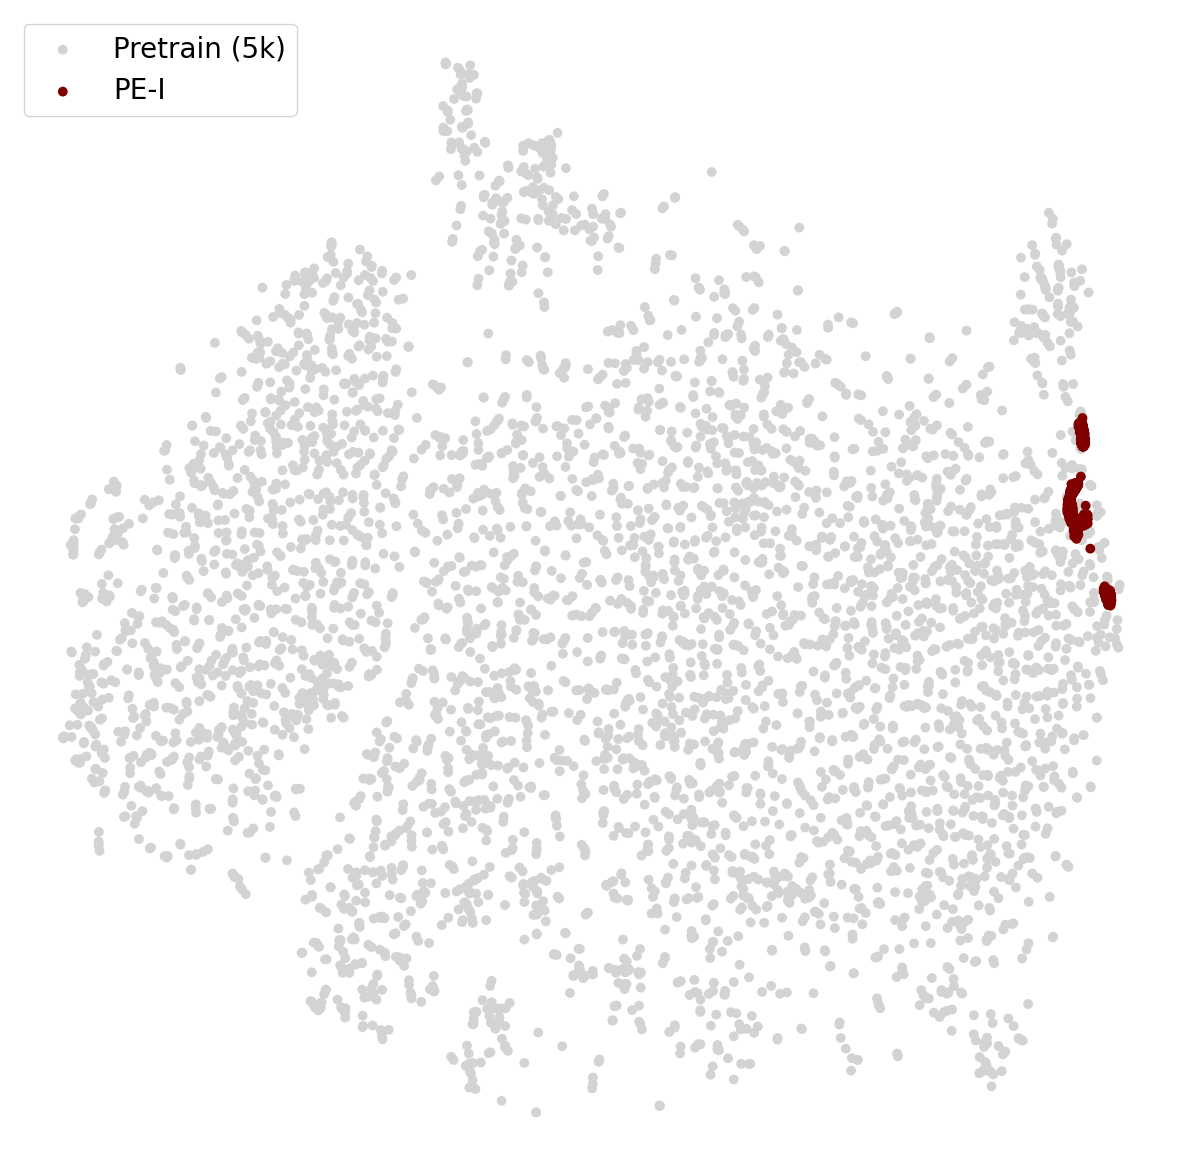

In [16]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(
    pretrain_tSNE[:, 0],
    pretrain_tSNE[:, 1],
    s=50,
    edgecolors='None',
    linewidths=0.4,
    c='lightgrey',
    label='Pretrain (5k)'
)
ax.scatter(
    PE_I_tSNE[:, 0],
    PE_I_tSNE[:, 1],
    s=50,
    edgecolors='None',
    linewidths=0.4,
    c='maroon',
    label='PE-I'
)

ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
ax.legend(fontsize=20, loc='upper left')
plt.savefig("tSNE_5k.png", bbox_inches='tight')

# Fine-tuning

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

In [18]:
best_r2 = 0.0

blocksize = 411
batch_size = 32
num_epochs = 20
warmup_ratio = 0.05
dropout_rate = 0.1
learning_rate = 0.00005
learning_rate_reg = 0.0001
weight_decay = 0.01

In [19]:
config = RobertaConfig(
  vocab_size=50265,#50265
  max_position_embeddings=411,
  num_attention_heads=12,#12
  num_hidden_layers=6,#6
  type_vocab_size=1,
  hidden_dropout_prob=0.1,
  attention_probs_dropout_prob=0.1
)
PretrainedModel = RobertaModel(config=config)
tokenizer = RobertaTokenizer.from_pretrained("roberta-base", max_len=blocksize)

In [20]:
vocab_sup = pd.read_csv("https://github.com/ChangwenXu98/TransPolymer/raw/refs/heads/master/data/vocab/vocab_sup_PE_I.csv", header=None).values.flatten().tolist()
tokenizer.add_tokens(vocab_sup)

643

In [21]:
print("Train Test Split")
train_data = pd.read_csv("https://github.com/ChangwenXu98/TransPolymer/raw/refs/heads/master/data/train_PE_I.csv")
test_data = pd.read_csv("https://github.com/ChangwenXu98/TransPolymer/raw/refs/heads/master/data/test_PE_I.csv")

Train Test Split


In [22]:
scaler = StandardScaler() # Normaliza os dados e diminui a variancia
train_data.iloc[:, 1] = scaler.fit_transform(train_data.iloc[:, 1].values.reshape(-1, 1))
test_data.iloc[:, 1] = scaler.transform(test_data.iloc[:, 1].values.reshape(-1, 1))

In [23]:
train_dataset = Downstream_Dataset(train_data, tokenizer, blocksize)
test_dataset = Downstream_Dataset(test_data, tokenizer, blocksize)
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=8)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=8)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [24]:
"""Parameters for scheduler"""
steps_per_epoch = train_data.shape[0] // batch_size
training_steps = steps_per_epoch * num_epochs
warmup_steps = int(training_steps * warmup_ratio)

In [25]:
"""Model"""

class DownstreamRegression(nn.Module):
  def __init__(self, drop_rate=0.1):
    super(DownstreamRegression, self).__init__()
    self.PretrainedModel = deepcopy(PretrainedModel)
    self.PretrainedModel.resize_token_embeddings(len(tokenizer))

    self.Regressor = nn.Sequential(
        nn.Dropout(drop_rate),
        nn.Linear(self.PretrainedModel.config.hidden_size, self.PretrainedModel.config.hidden_size),
        nn.SiLU(),
        nn.Linear(self.PretrainedModel.config.hidden_size, 1)
    )

  def forward(self, input_ids, attention_mask):
    outputs = self.PretrainedModel(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.last_hidden_state[:, 0, :]
    output = self.Regressor(logits)
    return output

In [26]:
def train(model, optimizer, scheduler, loss_fn, train_dataloader, device):

    model.train()

    for step, batch in enumerate(train_dataloader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        prop = batch["prop"].to(device).float()
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask).float()
        loss = loss_fn(outputs.squeeze(), prop.squeeze())
        loss.backward()
        optimizer.step()
        scheduler.step()

    return None

def test(model, loss_fn, train_dataloader, test_dataloader, device, scaler, optimizer, scheduler, epoch):

    r2score = R2Score()
    train_loss = 0
    test_loss = 0
    # count = 0
    model.eval()
    with torch.no_grad():
        train_pred, train_true, test_pred, test_true = torch.tensor([]), torch.tensor([]), torch.tensor(
            []), torch.tensor([])

        for step, batch in enumerate(train_dataloader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            prop = batch["prop"].to(device).float()
            outputs = model(input_ids, attention_mask).float()
            outputs = torch.from_numpy(scaler.inverse_transform(outputs.cpu().reshape(-1, 1)))
            prop = torch.from_numpy(scaler.inverse_transform(prop.cpu().reshape(-1, 1)))
            loss = loss_fn(outputs.squeeze(), prop.squeeze())
            train_loss += loss.item() * len(prop)
            train_pred = torch.cat([train_pred.to(device), outputs.to(device)])
            train_true = torch.cat([train_true.to(device), prop.to(device)])

        train_loss = train_loss / len(train_pred.flatten())
        r2_train = r2score(train_pred.flatten().to("cpu"), train_true.flatten().to("cpu")).item()
        print("train RMSE = ", np.sqrt(train_loss))
        print("train r^2 = ", r2_train)

        for step, batch in enumerate(test_dataloader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            prop = batch["prop"].to(device).float()
            outputs = model(input_ids, attention_mask).float()
            outputs = torch.from_numpy(scaler.inverse_transform(outputs.cpu().reshape(-1, 1)))
            prop = torch.from_numpy(scaler.inverse_transform(prop.cpu().reshape(-1, 1)))
            loss = loss_fn(outputs.squeeze(), prop.squeeze())
            test_loss += loss.item() * len(prop)
            test_pred = torch.cat([test_pred.to(device), outputs.to(device)])
            test_true = torch.cat([test_true.to(device), prop.to(device)])

        test_loss = test_loss / len(test_pred.flatten())
        r2_test = r2score(test_pred.flatten().to("cpu"), test_true.flatten().to("cpu")).item()
        print("test RMSE = ", np.sqrt(test_loss))
        print("test r^2 = ", r2_test)

    state = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'scheduler': scheduler.state_dict(),
             'epoch': epoch}
    torch.save(state, "PE_I_train.pt")

    return train_loss, test_loss, r2_train, r2_test, train_pred, train_true, test_pred, test_true

In [27]:
"""Train the model"""
model = DownstreamRegression(drop_rate=dropout_rate).to(device)
model = model.double()
loss_fn = nn.MSELoss()

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [28]:
optimizer = AdamW(
  [
    {"params": model.PretrainedModel.parameters(), "lr": learning_rate,
      "weight_decay": 0.0},
    {"params": model.Regressor.parameters(), "lr": learning_rate_reg,
      "weight_decay": weight_decay},
  ]
)

In [29]:
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=training_steps)

In [ ]:
torch.cuda.empty_cache()
train_loss_best, test_loss_best, best_train_r2, best_test_r2 = 0.0, 0.0, 0.0, 0.0 # Keep track of the best test r^2 in one fold. If cross-validation is not used, that will be the same as best_r2.
count = 0 # Keep track of how many successive non-improvement epochs
for epoch in range(1):
  print("epoch: %s/%s" % (epoch+1,1))
  #train(model, optimizer, scheduler, loss_fn, train_dataloader, device)
  train_loss, test_loss, r2_train, r2_test, train_pred, train_true, test_pred, test_true = test(model, loss_fn, train_dataloader, test_dataloader, device, scaler, optimizer, scheduler, epoch)
  if r2_test > best_test_r2:
    best_train_r2 = r2_train
    best_test_r2 = r2_test
    train_loss_best = train_loss
    test_loss_best = test_loss
    count = 0
  else:
    count += 1

  if r2_test > best_r2:
    best_r2 = r2_test
    state = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'scheduler': scheduler.state_dict(), 'epoch': epoch}
    torch.save(state, "PE_I_best_model.pt") # save the best model

  if count >= 5:
    print("Early stop")
    if best_test_r2 == 0:
        print("Poor performance with negative r^2")
    break

epoch: 1/1


# Results


train RMSE =  1.637812273704668

train r^2 =  -0.0320889949798584

test RMSE =  1.4309238123924557

test r^2 =  -0.3904300928115845

In [ ]:
temp_train_true = train_true.cpu()
temp_train_pred = train_pred.cpu()
temp_test_true = test_true.cpu()
temp_test_pred = test_pred.cpu()

In [ ]:
# Plot do gráfico da reta traçada
plt.scatter(temp_train_true, temp_train_pred, alpha=0.7, color='blue')
plt.plot([min(temp_train_true), max(temp_train_true)], [min(temp_train_true), max(temp_train_true)], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.show()

In [ ]:
# Plot do gráfico da reta traçada
plt.scatter(temp_test_true, temp_test_pred, alpha=0.7, color='blue')
plt.plot([min(temp_test_true), max(temp_test_true)], [min(temp_test_true), max(temp_test_true)], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.show()